In [154]:
import bids
from ghost.phantom import Caliber137
from ghost.math import make_sphere
import ants
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, distance_transform_edt
import numpy as np
from tqdm import tqdm

In [2]:
projdir = '/Users/emil/Projects/QA/CaliberPaper/ghost_bids_analysis'
layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')

# One example session to do everything
sub = 'P0004'
rec = 'axi'
ses = '20230705075534'
phantom = Caliber137()
run1 = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction=rec, session=ses, run=1)[0]
run2 = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction=rec, session=ses, run=2)[0]
fisp = layout.get(scope='raw', extension='.nii.gz', subject=sub, suffix='PDw', session=ses, run=None)[0]
sag = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction='sag', session=ses)[0]


# Process to get the fiducial segmentation

## 1. Reference phantom
We have the high resolution T2w phantom with the associated fiducial segmentation and our destination swoop image.

Ref T2w resolution: 0.96 x 0.96 x 0.90 mm3
Fiducial radius: 4.0 mm / 4.2 vox


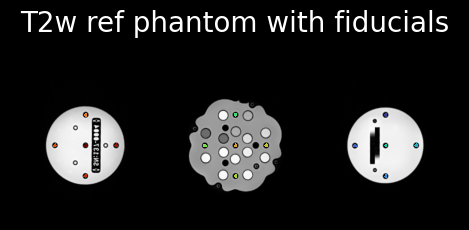

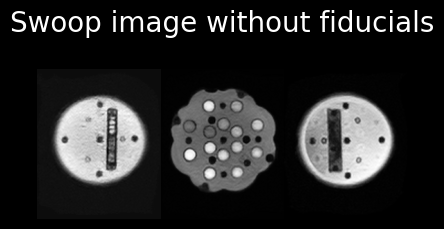

In [221]:
phantom_T2 = ants.image_read(phantom.get_phantom_nii(weighting='T2w'))
dx,dy,dz = phantom_T2.spacing
fid_radius_mm = int(phantom.get_specs()['Sizes']['Fiducials'])/2
fid_radius_vox = fid_radius_mm/dx
source_fid = ants.image_read(phantom.get_seg_nii('fiducials'))

print(f"Ref T2w resolution: {dx:.2f} x {dy:.2f} x {dz:.2f} mm3")
print(f"Fiducial radius: {fid_radius_mm} mm / {fid_radius_vox:.1f} vox")

phantom_T2.plot(axis=2, overlay=source_fid, slices=[34, 89, 145], title='T2w ref phantom with fiducials')

img = ants.resample_image(ants.image_read(run1.path), resample_params=[1.0, 1.0, 1.0], use_voxels=False, interp_type=4)

img.plot(axis=2, slices=[48, 98, 145], title='Swoop image without fiducials')

## 2. Initial registration
Now we do a first pass affine registration of the ref phantom to the swoop image to get an approximate location of the fiducials

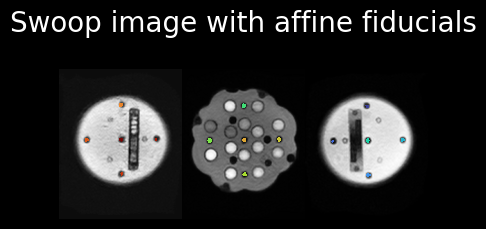

In [223]:
aff = ants.registration(img, phantom_T2, type_of_transform='Affine')
warp_fids = ants.apply_transforms(img, source_fid, transformlist=aff['fwdtransforms'], interpolator='genericLabel')
img.plot(axis=2, slices=[48, 98, 148], overlay=warp_fids, title='Swoop image with affine fiducials')

This is a pretty good first guess but we can make it better by doing a separate affine improved registration for each fiducial.

First we define a mask registration mask for each sphere in reference space

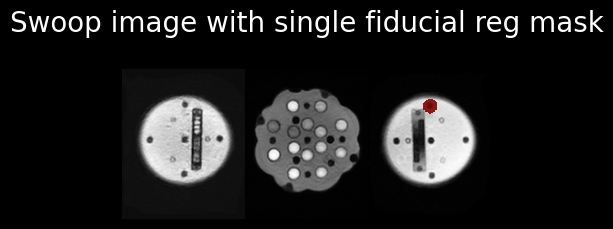

In [224]:
seg_np = source_fid.numpy()
com1 = center_of_mass(seg_np==1)
sphere_arr = make_sphere(seg_np.shape, fid_radius_vox*3, com1)
sphere_mask = ants.from_numpy(sphere_arr, origin=source_fid.origin, direction=source_fid.direction, spacing=source_fid.spacing)

sphere_mask_reg = ants.apply_transforms(img, sphere_mask, transformlist=aff['fwdtransforms'], interpolator='genericLabel')
phantom_mask_reg = ants.apply_transforms(img, ants.image_read(phantom.get_seg_nii('phantomMask')), 
                                         transformlist=aff['fwdtransforms'], interpolator='genericLabel')

sphere_mask_reg = sphere_mask_reg*phantom_mask_reg

img.plot(axis=2, slices=[48, 98, 148], overlay=sphere_mask_reg, title='Swoop image with single fiducial reg mask')

Now we take a single fiducial segmentation from reference space and co-register _the mask_ to the swoop image. Registering a binary mask isn't very good though so instead we calculate the euclidian distance. Let's break it down:

In [232]:
# Swoop distnance image
otsu = ants.otsu_segmentation(img, mask=sphere_mask_reg, k=1)
otsu_arr = (1-otsu.numpy())*sphere_mask_reg.numpy()
otsu_edt = ants.from_numpy(distance_transform_edt(otsu_arr), origin=otsu.origin, direction=otsu.direction, spacing=otsu.spacing)

# Ref imag
ref_edt = ants.from_numpy(distance_transform_edt((source_fid==1).numpy()), origin=source_fid.origin, direction=source_fid.direction, spacing=source_fid.spacing)

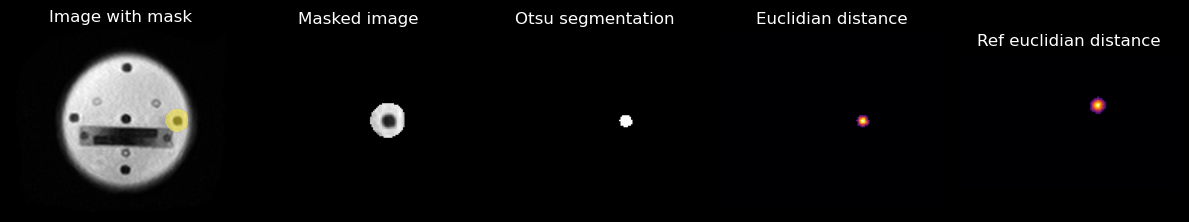

In [229]:
fig, axes = plt.subplots(1,5,figsize=(12,3))

ax = axes[0]
ax.imshow(img.numpy()[:,:,148], cmap='gray')
ax.imshow(sphere_mask_reg.numpy()[:,:,148], alpha=(sphere_mask_reg>0).numpy()[:,:,148].astype('float64')*0.5)
ax.set_title('Image with mask')

ax = axes[1]
ax.imshow((img*sphere_mask_reg).numpy()[30:-30,70:,148], cmap='gray'); ax.set_title('Masked image')

ax = axes[2]
ax.imshow(otsu_arr[30:-30,70:,148], cmap='gray'); ax.set_title('Otsu segmentation')

ax = axes[3]
ax.imshow(otsu_edt.numpy()[30:-30,70:,148], cmap='inferno'); ax.set_title('Euclidian distance')

ax = axes[4]
ax.imshow(ref_edt.numpy()[100:-80,100:-30,145], cmap='inferno')
ax.set_title('Ref euclidian distance')

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

In [231]:
reg = ants.registration(fixed=otsu_edt, 
                        moving=ref_edt, 
                        initial_transform=aff['fwdtransforms'][0], 
                        type_of_transform='Rigid',
                        mask=sphere_mask_reg,
                        mask_all_stages=True,
                        aff_metric='meansquares', 
                        aff_random_sampling_rate=1,
                        aff_iterations=(2000),
                        aff_shrink_factors=(1),
                        aff_smoothing_sigmas=(0))

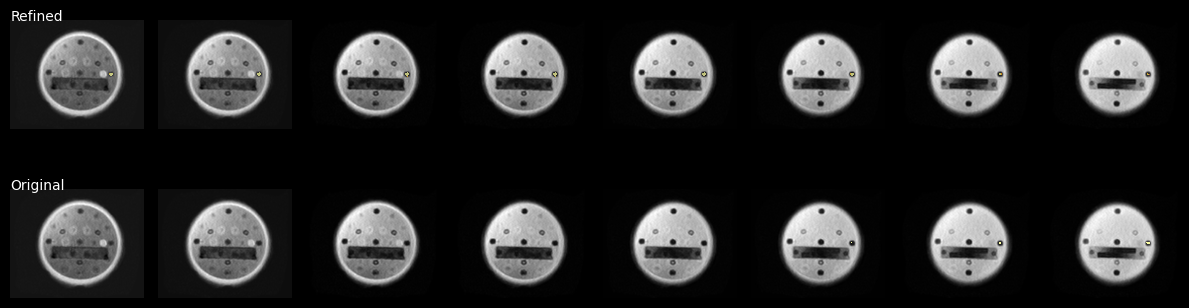

In [235]:
single_fid = (source_fid==1) 

fid_reg = ants.apply_transforms(img, single_fid, transformlist=reg['fwdtransforms'], interpolator='linear')
plt.style.use('dark_background')
fig, axes = plt.subplots(2,8,figsize=(12,4))

my_seg = fid_reg.numpy()
z0 = 142
for i,z in enumerate(np.arange(z0, z0+8)):
    s = my_seg[:,:,z]
    s[s==0] = np.nan
    axes[0,i].imshow(img.numpy()[:,:,z], cmap='gray')
    axes[0,i].imshow(s, cmap='inferno', alpha=0.75)
    axes[0,i].axis('off')
    if i==0:
        axes[0,i].text(x=0, y=0, s='Refined')

    my_s = np.zeros(warp_fids.shape)
    my_s[warp_fids.numpy()==1.0] = 1
    s = my_s[:,:,z]
    s[s==0] = np.nan
    axes[1,i].imshow(img.numpy()[:,:,z], cmap='gray')
    axes[1,i].imshow(s, cmap='inferno', alpha=1, vmin=0, vmax=1)
    axes[1,i].axis('off')
    if i==0:
        axes[1,i].text(x=0, y=0, s='Original')

plt.tight_layout()

Then we repeat the same procedure for each fiducial to get the final segmentations.


In [238]:
# Complete workflow in one cell
fname_input = run1.path

phantom_T2 = ants.image_read(phantom.get_phantom_nii(weighting='T2w'))
source_fid = ants.image_read(phantom.get_seg_nii('fiducials'))

dx,dy,dz = phantom_T2.spacing
fid_radius_mm = int(phantom.get_specs()['Sizes']['Fiducials'])/2
fid_radius_vox = fid_radius_mm/dx

img = ants.resample_image(ants.image_read(run1.path), resample_params=[1, 1, 1], use_voxels=False, interp_type=4)

# Affine registration to template
aff = ants.registration(img, phantom_T2, type_of_transform='Affine')

phantom_mask_reg = ants.apply_transforms(img, ants.image_read(phantom.get_seg_nii('phantomMask')), 
                                        transformlist=aff['fwdtransforms'], interpolator='genericLabel')

registrations = []
warp_fids = []
for fid_id in tqdm(range(1,16), desc='Refining fiducials'):
    com = center_of_mass((source_fid==fid_id).numpy())
    sphere_arr = make_sphere(seg_np.shape, fid_radius_vox*3, com)

    sphere_mask = ants.from_numpy(sphere_arr, origin=source_fid.origin, direction=source_fid.direction, spacing=source_fid.spacing)
    sphere_mask_reg = ants.apply_transforms(img, sphere_mask, transformlist=aff['fwdtransforms'], interpolator='genericLabel') * phantom_mask_reg
    
    # Swoop distnance image
    otsu = ants.otsu_segmentation(img, mask=sphere_mask_reg, k=1)
    otsu_arr = (1-otsu.numpy())*sphere_mask_reg.numpy()
    otsu_edt = ants.from_numpy(distance_transform_edt(otsu_arr), origin=otsu.origin, direction=otsu.direction, spacing=otsu.spacing)

    # Ref imag
    ref_edt = ants.from_numpy(distance_transform_edt((source_fid==fid_id).numpy()), origin=source_fid.origin, 
                              direction=source_fid.direction, spacing=source_fid.spacing)
    
    reg = ants.registration(fixed=otsu_edt, 
                        moving=ref_edt, 
                        initial_transform=aff['fwdtransforms'][0], 
                        type_of_transform='Rigid',
                        mask=sphere_mask_reg,
                        mask_all_stages=True,
                        aff_metric='meansquares', 
                        aff_random_sampling_rate=1,
                        aff_iterations=(2000),
                        aff_shrink_factors=(1),
                        aff_smoothing_sigmas=(0))
    
    registrations.append(reg)
    
    fid_reg = ants.apply_transforms(img, (source_fid == fid_id), transformlist=reg['fwdtransforms'], interpolator='linear')
    warp_fids.append(fid_reg)
    

Refining fiducials: 100%|██████████| 15/15 [01:01<00:00,  4.13s/it]


In [239]:
warp_fids[0]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (179, 218, 200)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-0.0, 216.0, -195.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [248]:
threshold = 0.5

my_fids = np.zeros([*warp_fids[0].shape, 15])
my_labels = np.zeros(warp_fids[0].shape)
for i in range(15):
    my_fids[...,i] = warp_fids[i].numpy()
    my_labels += np.where(warp_fids[i].numpy() > threshold, 1, 0) * (i+1)

all_fids = ants.from_numpy(np.sum(my_fids,axis=-1), spacing=img.spacing, origin=img.origin, direction=img.direction)
all_labels = ants.from_numpy(my_labels, spacing=img.spacing, origin=img.origin, direction=img.direction)

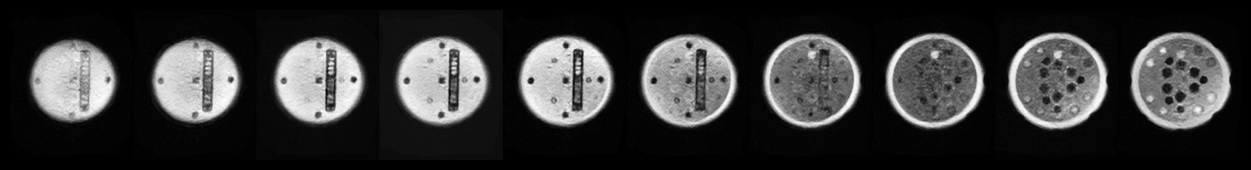

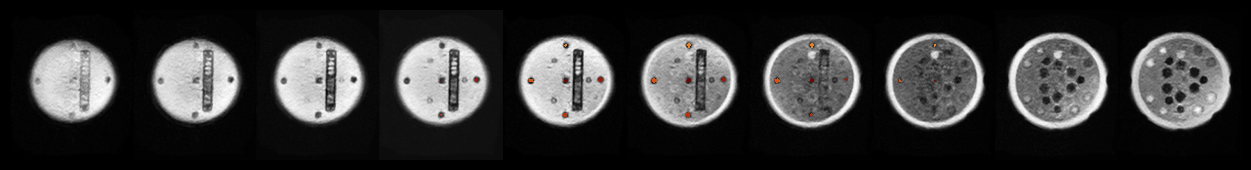

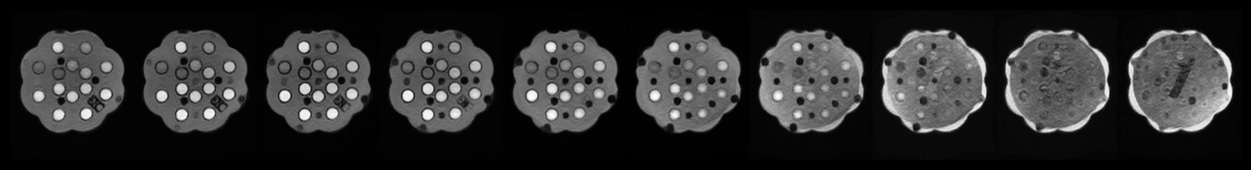

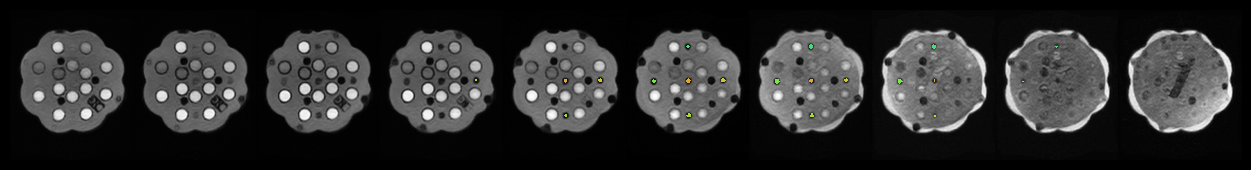

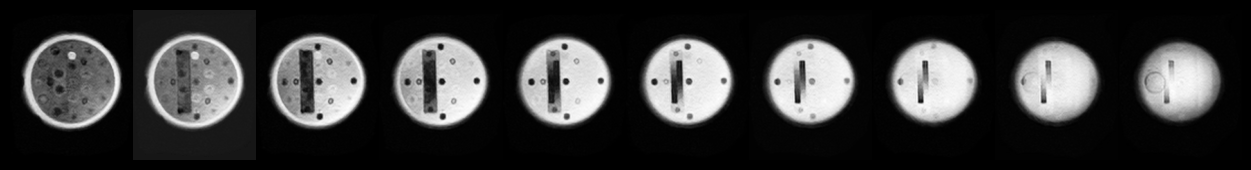

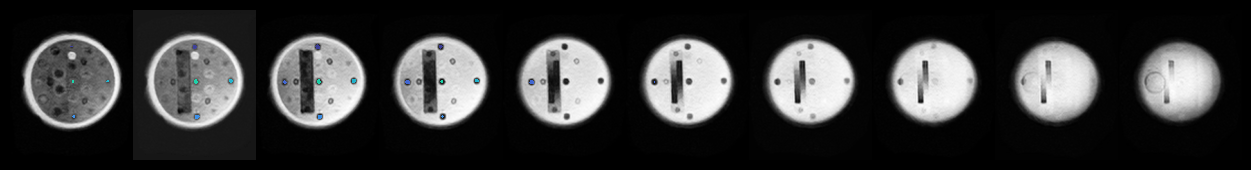

In [249]:
# 34, 89, 145
z0 = 42
img.plot(axis=2, slices=np.arange(z0,z0+20,2), ncol=10)
img.plot(axis=2, slices=np.arange(z0,z0+20,2), overlay=all_labels, ncol=10)

z0 = 90
img.plot(axis=2, slices=np.arange(z0,z0+20,2), ncol=10)
img.plot(axis=2, slices=np.arange(z0,z0+20,2), overlay=all_labels, ncol=10)

z0 = 140
img.plot(axis=2, slices=np.arange(z0,z0+20,2), ncol=10)
img.plot(axis=2, slices=np.arange(z0,z0+20,2), overlay=all_labels, ncol=10)


Once we have the fiducial segmentations we can calculate the position from the center of mass, or we can simply use the information stored in the affine. Let's see how much they differ from each other.

A given fiducial $k$ has a position $p_k$ in the design space, i.e., where the center fiducial is at $(0,0,0)$ and the other positions are given by their true distance from the center. We map the design space positions to the reference phantom positions with the affine transformation $A_D$, with subscript D indicating design space. The transformation from reference space to swoop space is given by the individual affine transformations $A_k$.

So, to get the position in swoop space $\hat{p}_k$ we calculate

$$
\hat{p}_k = A_k A_D p_k
$$

In [9]:
fid_reg

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (112, 136, 40)
	 Spacing    : (1.6, 1.6, 5.0)
	 Origin     : (-0.0, 216.0, -195.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [10]:
A_D = np.array(phantom.get_specs()['FiducialAffine'])
p1 = np.array(phantom.get_specs()['FiducialPositions']["1"])

A_1 = ants.read_transform(reg['fwdtransforms'][0])
p = ants.get_center_of_mass(fid_reg)
p1_ref = A_1.apply_to_point(p)
p1_ref
# p1_ref

(1.1299972534179688, -4.6233062744140625, -82.69498443603516)